# *03 - Yolo Syncpoint Detection*

## Team Members

* Daniel Bruckner

In [1]:
import os

os.chdir('..')

In [2]:
import numpy as np
import cv2
import sys
import tensorflow as tf

from tqdm import tqdm
from evaluate import YoloTest
from matplotlib import pyplot as plt
from skimage.transform import resize

/Users/Dani/anaconda2/envs/dl/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
yolo = YoloTest() 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoint/yolov3_test_loss=0.6454.ckpt-20


In [4]:
video_path = 'test_video/Test Videos_ds0_ANE 6-7A-1.mp4'

Open `VideoCapture` to be able to load the frames of the above mentioned video file:

In [5]:
cap = cv2.VideoCapture(video_path)

Get the total number of frames contained in the video file:

In [6]:
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Number of frames = {}".format(total_frames))

Number of frames = 1066


Load a random frame and see what the Yolo network finds in it:

In [13]:
%%time

cap.set(cv2.CAP_PROP_POS_FRAMES, 60)
_, image = cap.read()

CPU times: user 215 ms, sys: 12.4 ms, total: 227 ms
Wall time: 132 ms


Create a mapping dictionary to be able to get the class name from the class index:

In [14]:
ground_truth_value = {1:'open', 0:'closed'}

In [15]:
CLASS_INDEX_DICT = {'open': 1, 'closed': 0}

One forward pass in the network:

In [16]:
%%time

forward_pass = yolo.predict(image)

CPU times: user 6.27 s, sys: 300 ms, total: 6.57 s
Wall time: 2.35 s


In [17]:
forward_pass

[array([206.52038574,  59.88507462, 716.80041504, 497.53289795,
          0.95039517,   1.        ])]

In [18]:
pred = forward_pass[0][0:4].astype(np.int32)
y_hat = forward_pass[0][4:]
classname = ground_truth_value[int(y_hat[1])]
confidence = y_hat[0]

print("BBox = {}".format(pred))
print("Classname = {}".format(classname))
print("Confidence = {}".format(confidence))

BBox = [206  59 716 497]
Classname = open
Confidence = 0.9503951668739319


Visualize the result by drawing the bounding box along with the class name and its confidence value:

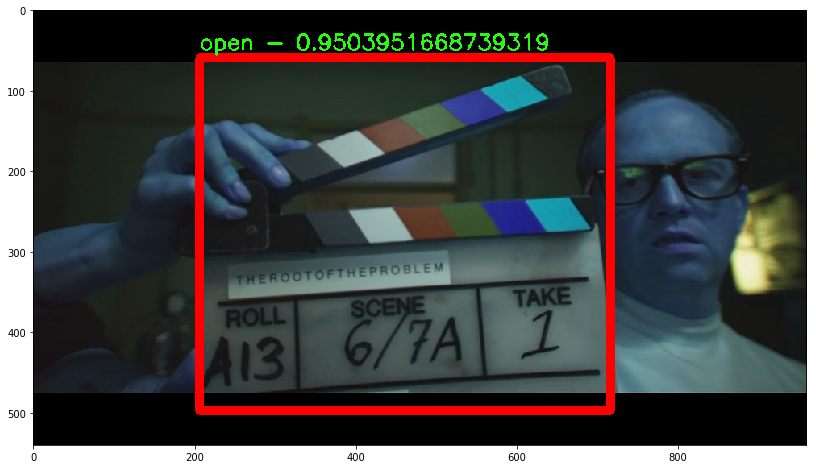

In [19]:
_, image = cap.read()
cv2.rectangle(image, (pred[0], pred[1]), (pred[2], pred[3]), (255,0,0), 10)
cv2.putText(image, '{} - {}'.format(classname, confidence), (pred[0], pred[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

plt.figure(figsize=(20,8))
plt.imshow(image)

## Jump Search

A Jump Search algorithm is a bit faster than the Linear Search algorithm, because it doesn't scan every single frame. It rather jumps through the array by a fixed step size and stops once it reaches the area in which the element it searches for exists. After that, it goes through each element until the desired element is found. This is applied to sorted lists, of course. 

<BR>
    
In our case, we have to modify that algorithm a little bit to make it work on video files:
    
* Jump through each frame by a predefined sample rate
* Save the frames in which Yolo detects a slate with high confidence (to prevent it from finding too many false positives, which would make the search very slow)
* Iterate through the slate-containing frames one by one and save the confidences and class indexes until Yolo stops finding any slates in the video
* Find the syncpoints using the confidences and class indexes

In [20]:
def jump_search(video_path, model, sample_rate, confidence_threshold):
    predictions = dict()
    
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
    for i in tqdm(range(0, total_frames, sample_rate)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        _, img = cap.read()
        prediction = model.predict(img)
        
        if len(prediction) > 0 and prediction[0][4] >= confidence_threshold:
            predictions[i] = prediction[0]         
    
    return predictions

Perform the actual search:

In [21]:
%%time

search_results = jump_search(video_path=video_path, model=yolo, sample_rate=30, confidence_threshold=0.85)

100%|██████████| 36/36 [01:20<00:00,  2.25s/it]

CPU times: user 3min 55s, sys: 11.1 s, total: 4min 6s
Wall time: 1min 20s


These are the frames that were found to contain a slate with a confidence $>=0.85$:

In [22]:
frames_detected = np.array(list(search_results.keys()))
frames_detected

array([ 0, 30, 60, 90])

Display discovered clapper boards:

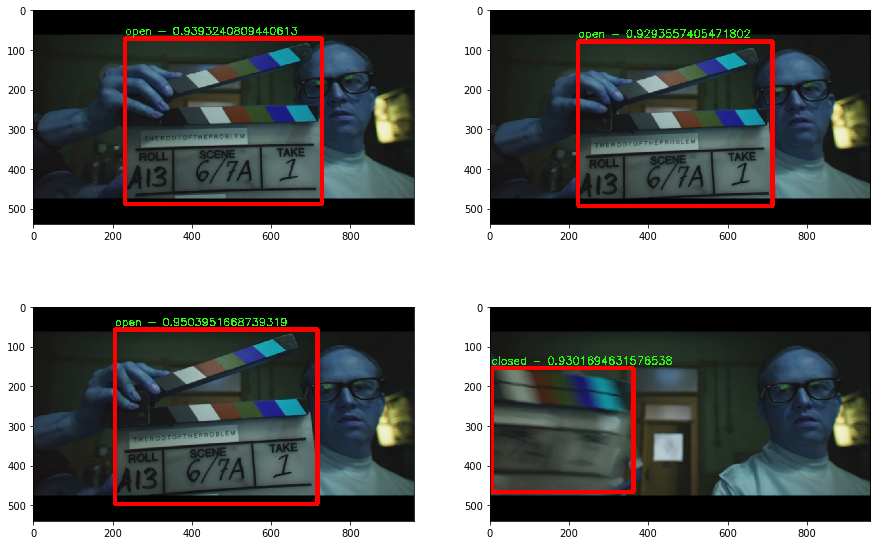

In [23]:
fig=plt.figure(figsize=(15, 10))

# Define a start index to display odd numbered frames or even numbered frames
start_index = 0
columns = 2
rows = len(frames_detected) // columns

for i in range(1, columns * rows + 1):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frames_detected[(i - 1) + start_index])
    _, img = cap.read()
    
    forward_pass = yolo.predict(img)
    
    pred = forward_pass[0][0:4].astype(np.int32)
    y_hat = forward_pass[0][4:]
    classname = ground_truth_value[int(y_hat[1])]
    confidence = y_hat[0]
    
    cv2.rectangle(img, (pred[0], pred[1]), (pred[2], pred[3]), (255,0,0), 10)
    cv2.putText(img, '{} - {}'.format(classname, confidence), (pred[0], pred[1]-10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    
plt.show()
plt.tight_layout()

What we can see is that it works pretty will, since it didn't keep any frames containing false positives. 
In our case, it is very important to tune for precision, because we don't want any wrong syncpoints in our video editing timeline.

### Search for the exact syncpoints

Most of the time the slates that Yolo found are in the middle of am sequence. To find the syncpoints, we use the confidence scores and the class indexes aling with the frame numbers (as identifiers) of each sequence. So, we have to scan forwards and backwards, starting from the frame that Yolo found.  

In [24]:
def predict_frame(frame, cap, model):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
    _, img = cap.read()
    return model.predict(img)

def move_backward(frame, cap, model):
    done = False
    states = list()
    
    while not done:
        pred = predict_frame(frame, cap, model)
        
        if len(pred) > 0:
            pred = pred[0]
            states.append([pred[4], pred[5], frame])
        else:
            # TODO look two frames ahead
            done = True
        frame -= 1
    
    return states    

def move_forward(frame, cap, model):
    done = False
    states = list()
    
    while not done:
        pred = predict_frame(frame, cap, model)
        
        if len(pred) > 0:
            pred = pred[0]
            states.append([pred[4], pred[5], frame])
        else:
            # TODO look two frames ahead
            done = True
        frame += 1

    return states    

To get the whole sequence in its right order, we have to first flip the backward-scanned states-array to restore the proper order. Then we concatenate the backward states to the forward states to get the whole sequence values in the correct order for later analysis:

In [25]:
def inspect_frame_environment(frame, cap, model):
    states_backward = move_backward(frame, cap, model)
    states_forward = move_forward(frame, cap, model)

    return np.concatenate((np.flip(states_backward, axis=0), states_forward))

Inspect the environment around all of the discovered slates in the film to find their syncpoint - the points at wihich they are clapped and concatenate the results of each individual environment scan. Also, to avoid scanning frames more than once, we have to check whether the Yolo-frame from the Jump Search has already been scanned and if so, skip it. This saves us computation time, which is important to keep the scanning time low for the user.

In [19]:
def inspect_frame_environments(slate_frames, cap, model):
    frame_environments = list()
    search_space = list()
    
    # Emulate a do while loop here
    frame_environment = inspect_frame_environment(slate_frames[0], cap, model)
    frame_environments.append(frame_environment)
    search_space = np.concatenate(frame_environments)
    
    for slate_frame in slate_frames:
        if slate_frame not in search_space[:, 2]:
            frame_environment = inspect_frame_environment(slate_frame, cap, model)
            frame_environments.append(frame_environment)
            search_space = np.concatenate(frame_environments)
    
    return search_space

In [76]:
%%time

frame_envs = inspect_frame_environments(slate_frames=frames_detected, cap=cap, model=yolo)

CPU times: user 5min 30s, sys: 8.58 s, total: 5min 39s
Wall time: 42.3 s


Method for finding the actual syncpoints:

In [38]:
def find_sync_points(slate_states):
    syncpoints = list()
    gt_1 = np.array(slate_states).astype(np.float32).astype(np.int32)

    for i in range(len(gt_1) - 1):
        state_0 = gt_1[i]
        state_1 = gt_1[i + 1]

        if state_0 == 1 and state_1 == 0:
            syncpoints.append(i + 1)
    
    return syncpoints

Detect syncpoints with a confidence threshold to avoid false positives: 

In [70]:
def improved_syncpoint_detection(predicted_states, confidence_values, 
                                 confidence_margin, confidence_threshold):
    
    detected_syncpoints = find_sync_points(predicted_states)
    detected_syncpoints_clean = list()
    
    confidence_values[np.where(confidence_values == None)] = 0.5
    
    for p in detected_syncpoints:
        average_confidence_left = np.mean(confidence_values[p - confidence_margin:p])
        average_confidence_right = np.mean(confidence_values[p:p + confidence_margin])
        average_confidence = (average_confidence_left + average_confidence_right) / 2
        
        if average_confidence >= confidence_threshold:
            detected_syncpoints_clean.append(p)
    
    return detected_syncpoints_clean

In [23]:
def search_frame_environments_for_syncpoints(frame_envs, confidence_margin=7, confidence_threshold=0.85):
    syncpoint_frames = list()
    
    predicted_states = frame_envs[:, 1].astype(np.int32)
    confidences = frame_envs[:, 0]

    
    
    syncpoint_idxs = improved_syncpoint_detection(predicted_states, confidences, 
                                                  confidence_margin, confidence_threshold)
    
    for idx in syncpoint_idxs:
        syncpoint_frames.append(frame_envs[idx][2])
    
    return np.array(syncpoint_frames, dtype=np.int32)

In [24]:
syncpoints = search_frame_environments_for_syncpoints(frame_envs)
print("Syncpoints = {}".format(syncpoints))

Syncpoints = [  37 7469]


## Multi-Threaded Search

In [24]:
import threading
import time

Using multiple threads will speed up the search process. We will split the video file into chunks and assign each chunk to a single thread. This way, they don't interfere with each other while still working together.

In [25]:
video_path = 'test_video/Test Videos_ds0_ANE 6-7A-1.mp4'

Redefine the `jump_search` so that it is possible to search only chunks of the video file:

In [26]:
def jump_search(video_path, model, sample_rate, confidence_threshold, chunk, threadID, predictions):
    cap = cv2.VideoCapture(video_path)
    
    j = 0
    
    for i in range(chunk[0], chunk[1], sample_rate):
        
        if j % 100 == 0:
            print("Thread {} - frame {}/{}".format(threadID, i, chunk[1]))
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        _, img = cap.read()
        prediction = model.predict(img)
        j += sample_rate
        
        if len(prediction) > 0 and prediction[0][4] >= confidence_threshold:
            predictions[i] = prediction[0] 

Define the thread object for slate searching in the video file:

In [27]:
class SearchThread(threading.Thread):
    
    def __init__(self, threadID, video_path, model, sample_rate, 
                 confidence_threshold, chunk, predictions):
        
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.video_path = video_path
        self.model = model
        self.sample_rate = sample_rate
        self.confidence_threshold = confidence_threshold
        self.chunk = chunk
        self.predictions = predictions
        
    def terminate(self): 
        self._running = False
    
    def run(self):
        self.start = time.time()
        print("Starting SearchThread {}".format(self.threadID))
        jump_search(self.video_path, self.model, self.sample_rate, 
                    self.confidence_threshold, self.chunk, self.threadID, self.predictions)
        print("Thread {} Done".format(self.threadID))
        self.end = time.time()
        
        

Create a method that allows us to measure the execution time of the threads. It gets all of the thread objects as input and calculates the time difference between the earliest starting thread and the latest stopping thread. 
We define this as the execution time of the whole process. 
This method has to be run once all of the threads have finished execution. Otherwise it won't be able to access the start and end times.

In [28]:
def get_execution_time(workers):
    min_start_time = sys.maxsize
    max_end_time = -sys.maxsize - 1
    
    for worker in workers:
        if worker.start < min_start_time:
            min_start_time = worker.start
        
        if worker.end > max_end_time:
            max_end_time = worker.end
    
    return max_end_time - min_start_time

Build a method to spawn threads and automatically assign a file chunk to them:

In [29]:
SAMPLE_RATE = 30
CONFIDENCE_THRESHOLD = 0.85

In [30]:
def multi_threaded_search(workers, video_path, model, sample_rate, confidence_threshold, nb_frames):
    preds = dict()
    worker_objects = list()
    
    for i in range(workers):
        lower_border = nb_frames // workers * i
        
        if i == workers - 1:
            upper_border = nb_frames
        else:
            upper_border = nb_frames // workers * (i + 1)
        
        
        chunk = (lower_border, upper_border)
        worker = SearchThread(i, video_path, model, sample_rate, confidence_threshold, chunk, preds)
        worker_objects.append(worker)
        worker.start()
    
    for worker in worker_objects:
        worker.join()
    
    return preds, worker_objects

preds, worker_objects = multi_threaded_search(4, video_path, yolo, SAMPLE_RATE, CONFIDENCE_THRESHOLD, total_frames)

Starting SearchThread 0Starting SearchThread 1

Thread 0 - frame 0/266Starting SearchThread 2

Starting SearchThread 3
Thread 2 - frame 532/798Thread 1 - frame 266/532

Thread 3 - frame 798/1066
Thread 0 Done
Thread 2 Done
Thread 3 Done
Thread 1 Done


In [31]:
print("Execution time = {}".format(get_execution_time(worker_objects)))

Execution time = 84.4057240486145


As expected, this has already given us a significant decrease in computation time from **1 min 30s** to **31 seconds**. We also did an experiment where we used 10 workers. However, that didn't lead to any high improvement over the 4 threads we are currently using. 
The reason for that might be that the CPU only has 4 cores that can execute tasks concurrently.

## Improve time to find the syncpoint

As of now, the method for finding the syncpoint is very inefficient, since it scans every frame of the video where the network can find a slate. This takes a long time to finish and can be improved.

In [32]:
slate_frames = np.array(sorted(list(preds.keys())))
slate_frames

array([ 0, 30, 60, 90])

We ran the analyzer through the video file to find the frames that contain a clapperboard. The next step is to find out which detected frames belong to the same clapperboard sequence (meaning the same scene that the clapperboard marks in the video).
It is very likely that if the detected frames are as far apart as the `sample_rate` (or less) that they belong to one scene. On the other side, if they are further apart, they belong to different scenes. 
We need this information to know how many syncpoints we can expect in the file and where to expect them. To effectifely search using a binary search algorithm that we will define later, we have to know how many syncpoints we have to search for.

In [34]:
def group_slate_frames(frames, sample_rate):    
    groups = list()
    
    prev_frame = frames[0]
    current_group = [frames[0]]
    
    for i, frame in enumerate(frames[1:]):
        diff = frame - prev_frame
       
        if diff > sample_rate or i == (len(frames[1:]) - 1):
            print("group done")
            if len(current_group) > 0:
                groups.append(current_group)

            current_group = list()
            current_group.append(frame)
       
        elif diff <= sample_rate:
            current_group.append(frame)
        
        prev_frame = frame
        
    return groups

group_slate_frames(slate_frames, SAMPLE_RATE)

group done


[[0, 30, 60]]

### Find Syncpoint for group

Make predictions for a specific frame along with a window of the following and previous frame to be able to inspect if the syncpoint is behind or after the current frame.

In [35]:
def make_predictions(frame_number, cap, model):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    _, image = cap.read()
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number - 1)
    _, prev_image = cap.read()
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number + 1)
    _, next_image = cap.read()
    
    current_prediction = {'frame_number': frame_number, 'pred': np.array(model.predict(image))}
    previous_prediction = {'frame_number': frame_number - 1, 'pred': np.array(model.predict(prev_image))}
    next_prediction = {'frame_number': frame_number + 1, 'pred': np.array(model.predict(next_image))}
    
    return previous_prediction, current_prediction, next_prediction 

Get multiple prediction arrays and condense only the class indexes into one array. This way, we can easier process the result in the algorithm and decide whether to move forward or backward:

In [36]:
def get_class_indexes(predictions):
    idxs = list()
    
    for pred in predictions:
        if len(pred['pred']) > 0:
            idxs.append(int(pred['pred'][0][-1]))
        
    return idxs

Previously, we looked at the sorrounding of a syncpoint (candidate) to see if the confidence is good enough for it to be a legitimate syncpoint. In this case, if we have a candidate for a syncpoint, we don't have enough information about its sorrounding area. The reason is that only three frames are predicted, which is not enough to get a picture of the syncpoint being legitimate when looking at the confidence. We have to predict a couple of frames before and after the candidate frame number to be able to calculate an average confidence that is meaningful.

In [37]:
def pad_final_prediction(frame_number, padding, cap, model):
    padded_prediction = list()
    
    # backward padding
    j = frame_number - padding - 1
    for i in range(padding):
        current_frame = j + i + 1
        print("Padding frame = {}".format(current_frame))
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
        _, image = cap.read()
        prediction = model.predict(image)
        
        class_idx = prediction[0][-1]
        conf = prediction[0][-2]
        padded_prediction.append(np.array([current_frame, class_idx, conf]))
    
    
    #forward padding 
    j = frame_number
    for i in range(padding + 1):
        current_frame = j + i
        print("Padding frame = {}".format(current_frame))
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, j + i)
        _, image = cap.read()
        prediction = model.predict(image)
        
        class_idx = prediction[0][-1]
        conf = prediction[0][-2]
        padded_prediction.append(np.array([current_frame, class_idx, conf]))
        
    return np.array(padded_prediction)

padded_prediction = pad_final_prediction(frame_number=73, padding=4, cap=cap, model=yolo)

Padding frame = 69
Padding frame = 70
Padding frame = 71
Padding frame = 72
Padding frame = 73
Padding frame = 74
Padding frame = 75
Padding frame = 76
Padding frame = 77


This is a modified version of the syncpoint detection + sorrounding confidence scan. It only tries to find one syncpoint in a sequence, since it now only contains up one syncpoint.

In [39]:
def improved_syncpoint_detection_binary(frames, predicted_states, confidence_values, 
                                 confidence_margin, confidence_threshold):
    
    detected_syncpoints = find_sync_points(predicted_states)
    detected_syncpoints_clean = list()
    
    confidence_values[np.where(confidence_values == None)] = 0.5
    
    for p in detected_syncpoints:
        avg_conf = np.mean(confidence_values)
        print("Syncpoint candidate found!")
        print("Average Detection Confidence = {}".format(avg_conf))
        
        if avg_conf >= confidence_threshold:
            return int(frames[p])

In [40]:
improved_syncpoint_detection_binary(padded_prediction[:, 0], padded_prediction[:, 1], padded_prediction[:, 2], 4, 0.85,)

Syncpoint candidate found!
Average Detection Confidence = 0.8056424260139465


If the prediction didn't find any clapperboards in the frame, it is probably because the pivot ended up in the area before or after the clapperboard appears in the video. We could search for the exact frame that the clapperboard appears and disappears, but that would take too much computation power and time. Since we don't yet know if the neural net is going to work with GPU-Support, we should save unnecessary searching. Alternatively, we can create a heuristic that fills in the empty predictions with the class indexes that are most probable. In this case, the heuristic would be the class indexes closer to the last frame are `closed` and vice versa. This way, we can direct the search algorithm without impreding it.

In [41]:
def fill_empty_predictions(first_frame, last_frame, current_frame):
    open_idx = CLASS_INDEX_DICT['open']
    closed_idx = CLASS_INDEX_DICT['closed']

    
    if abs(last_frame - current_frame) < abs(first_frame - current_frame):
        return [closed_idx, closed_idx, closed_idx]
    else:
        return [open_idx, open_idx, open_idx]

Before starting the search, define start and end points of the search window. These are `start_frame - sample_rate` and `end_frame + sample_rate`. The reason being that we want to make sure we include all possible slate frames into the window to not miss any syncpoints.

In [46]:
def syncpoint_search_fast(first_frame_number, last_frame_number, 
                          sample_rate, model, cap, max_steps=20, max_retries=1):
    N = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    first_frame_number = first_frame_number - sample_rate
    
    if first_frame_number < 0:
        first_frame_number = 0
    
    last_frame_number = last_frame_number + sample_rate
    
    if last_frame_number > N:
        last_frame_number = N
    
    print("Searching frames {} - {}".format(first_frame_number, last_frame_number))
    
    step_size = (last_frame_number - first_frame_number) // 2
    frame_number = last_frame_number - step_size
    
    return syncpoint_binary_search(first_frame_number, last_frame_number, frame_number, step_size, 
                                   step_size, model, cap, max_steps, max_retries)   

If the algorithm doesn't find any syncpoints with a high enough confidence, it starts again at a random location to find the real syncpoint. Sometimes, there is no other syncpoint and we have to return the low-confidence syncpoint. Because of the search-algorithm omitting the output on low confidence, we can just return the candidate to have some result (that may as well be correct). 
For the result to be frame-level accurate, we remove the offset that the current frame has towards the prediction-indexes in the window. An example would be that if the syncpoint candidate was found at the end of the window (`[1, 1, 0]`), we just add one frame to the current frame to get the sync frame to return.

In [55]:
def return_syncpoint_on_timeout(frame_number, class_indexes):
    sync_index = np.where(class_indexes==0)[0][0]
    return (frame_number - (sync_index - 1))

return_syncpoint_on_timeout(74, np.array([1, 1, 0]))

Sync Index = 2
Frame Number = 74


73

Do a [Binary Search](https://en.wikipedia.org/wiki/Binary_search_algorithm) on the previously defined window. 
If a syncpoint is, check if it is legitimate by looking at the average confidence in its sorrounding area. If it is below a certain threshold (The best threshold `0.85`, the best window size is `4` --> *Grid Search result*) start the search again at a random starting point until the syncpoint was found (or a ceratin number of steps has been reached)

In [54]:
def syncpoint_binary_search(first_frame, last_frame, frame_number, step_size, 
                            original_step_size, model, cap, max_steps, max_retries):
    print("Frame = {}".format(frame_number))        
    print("Step Size = {}".format(step_size))
    
    if max_steps == 0:
        return
    
    if step_size == 1:
        max_steps -= 1
    
    predictions = make_predictions(frame_number, cap, model)
    class_indexes = get_class_indexes(predictions)
    
    if len(class_indexes) == 0:
        class_indexes = fill_empty_predictions(first_frame, last_frame, frame_number)
    
    print(class_indexes)
    
    
    if np.mean(class_indexes) == 1.:
        
        # step forth when it's open
        new_step_size = np.ceil(step_size / 2)
        new_frame_number = frame_number + new_step_size
        
        return syncpoint_binary_search(first_frame, last_frame, new_frame_number, new_step_size, 
                                       original_step_size, model, cap, max_steps, max_retries)
    
    elif np.mean(class_indexes) == 0.:
        
        # step back when it's closed
        new_step_size = np.ceil(step_size / 2)
        new_frame_number = frame_number - new_step_size
        
        return syncpoint_binary_search(first_frame, last_frame, new_frame_number, new_step_size, 
                                       original_step_size, model, cap, max_steps, max_retries)
    
    else:
        padded_indexes = pad_final_prediction(frame_number=frame_number, padding=2, cap=cap, model=model)
        syncpoint =  improved_syncpoint_detection_binary(padded_indexes[:, 0], padded_indexes[:, 1], 
                                                          padded_indexes[:, 2], 4, 0.85)
        
        if syncpoint != None:
            return syncpoint
        else:
            if max_retries == 0:
                print("Max. retries reached. Returning most likely sync point")
                return return_syncpoint_on_timeout(frame_number, np.array(class_indexes))
            
            print("Candidate unlikely to be correct. Restarting search from random frame.")
            new_frame_number = np.random.randint(first_frame, last_frame)
            return syncpoint_binary_search(first_frame, last_frame, new_frame_number, original_step_size, 
                                           original_step_size, model, cap, max_steps, max_retries - 1)

syncpoint = syncpoint_search_fast(first_frame_number=0, last_frame_number=90, 
                                  sample_rate=30, model=yolo, cap=cap, max_steps=20, max_retries=0)

Searching frames 0 - 120
Frame = 60
Step Size = 60
[1, 1, 1]
Frame = 90.0
Step Size = 30.0
[0, 0, 0]
Frame = 75.0
Step Size = 15.0
[1, 0, 0]
Padding frame = 73.0
Padding frame = 74.0
Padding frame = 75.0
Padding frame = 76.0
Padding frame = 77.0
Syncpoint candidate found!
Average Detection Confidence = 0.6871100902557373
Max. retries reached. Returning most likely sync point
Sync Index = 1


This is the result:

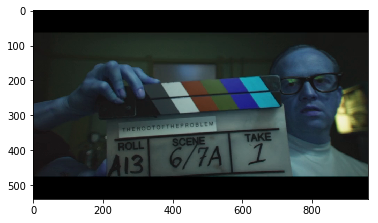

In [56]:
cap.set(cv2.CAP_PROP_POS_FRAMES, syncpoint)
_, img = cap.read()
plt.imshow(img)

### Find all syncpoints using the previously defined method

In [57]:
groups = group_slate_frames(slate_frames, SAMPLE_RATE)
groups

group done


[[0, 30, 60]]

Loop through all the groups and take the first and last frames as as search window inputs. 

In [59]:
%%time

def find_all_syncpoints_binary(groups, sample_rate, model, cap):
    syncpoints = list()
    
    for group in groups:
        first_frame = group[0]
        last_frame = group[-1]
        
        syncpoint = syncpoint_search_fast(first_frame, last_frame, sample_rate, model, cap)
        syncpoints.append(syncpoint)
        
        print("Syncpoint = {}".format(syncpoint))
        print("-"*100)
        
    return syncpoints

syncpoints = find_all_syncpoints_binary(groups=groups, sample_rate=30, model=yolo, cap=cap)
syncpoints

Searching frames 0 - 90
Frame = 45
Step Size = 45
[1, 1, 1]
Frame = 68.0
Step Size = 23.0
[1, 1, 1]
Frame = 80.0
Step Size = 12.0
[0, 0, 0]
Frame = 74.0
Step Size = 6.0
[1, 1, 0]
Padding frame = 72.0
Padding frame = 73.0
Padding frame = 74.0
Padding frame = 75.0
Padding frame = 76.0
Syncpoint candidate found!
Average Detection Confidence = 0.7652900695800782
Candidate unlikely to be correct. Restarting search from random frame.
Frame = 50
Step Size = 45
[1, 1, 1]
Frame = 73.0
Step Size = 23.0
[1, 1, 1]
Frame = 85.0
Step Size = 12.0
[0, 0, 0]
Frame = 79.0
Step Size = 6.0
[0, 0, 0]
Frame = 76.0
Step Size = 3.0
[0, 0, 0]
Frame = 74.0
Step Size = 2.0
[1, 1, 0]
Padding frame = 72.0
Padding frame = 73.0
Padding frame = 74.0
Padding frame = 75.0
Padding frame = 76.0
Syncpoint candidate found!
Average Detection Confidence = 0.7652900695800782
Max. retries reached. Returning most likely sync point
Sync Index = 2
Frame Number = 74.0
Syncpoint = 73.0
----------------------------------------------

In [62]:
syncpoints

[73.0]

As we can see, it worked quite well and didn't take a long time to finish. We had one time where we had restart the search a couple of times. This was due to a false positive on behalf of the network. No actual syncpoint was seen there. But, the average confidence was too low and the whole restarted until it found the real syncpoint. So, this shows that our method works even if the network sometimes finds wrong syncpoints. This will get better the more data we have and the more robust the network gets.

Depending on how well Yolo performs in the final test and if we can use it with PlaidML, this might be an option for the final deployed tool.